In [305]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, namedtuple
from itertools import product
import matplotlib as mpl

%matplotlib inline

mpl.rcParams['figure.figsize'] = (7.0, 5.0)  # default size of plots
mpl.rcParams['font.size'] = 16

In [99]:
# Convert each %MSG-i...%MSG block into a dict
def parse_file(f, entries):
    parse_event = False
    entry = None
    for line in f:
        line = line.strip()
        if line.startswith('%MSG-i') and 'Run' in line:
            parts = line.split()
            entry = dict(
                msg=parts[1].strip(":"),
                module=parts[2].strip(),
                run=parts[-3],
                event=parts[-1],
                contents=[])
            parse_event = True
            continue
        elif line == '%MSG' and parse_event:
            parse_event = False
#             print entry
            entries.append(entry)
        if parse_event:
            entry['contents'].append(line.strip())
#     print entries[0]

In [100]:
entries = []
files = ['zb.config.908944.0.err', 'zb.config.908949.0.err', 'zb.config.908954.0.err', 'zb.config.908958.0.err', 
         'zb.config.908973.0.err', 'zb.config.908974.0.err', 'zb.config.908976.0.err', 'zb.config.908978.0.err', 
         'zb.config.908986.0.err', 'zb.config.908987.0.err', 'zb.config.908988.0.err', 'zb.config.908989.0.err', 
         'zb.config.908993.0.err', 'zb.config.908994.0.err', 'zb.config.908995.0.err', 'zb.config.909008.0.err']
for fin in files:
    with open(fin) as f:
        parse_file(f, entries)

# with open('zb.config.908944.0.err') as f:
#     parse_file(f, entries)

In [101]:
print len(entries)

7989


In [102]:
# Filter only L1T* modules
entries = [e for e in entries if "L1T" in e['module']]

In [103]:
len(entries)

7892

In [104]:
entries[0]

{'contents': ['Jet PT Pre: 19 eta: -4 phi: 22'],
 'event': '48450783',
 'module': 'L1TStage2Layer2Producer:simCaloStage2Digis',
 'msg': 'LUTCalibration',
 'run': '272022'}

In [105]:
event_nums = sorted(set([int(e['event']) for e in entries]))

In [106]:
print len(event_nums)

853


For each event number, we want: 

- pre-calibrated MP jet et/eta/phi

- post-calibrated MP jet et/eta/phi

- data MP jet et/eta/phi

In [338]:
class Jet(object):
    def __init__(self, et=0, eta=0, phi=0):
        self.et = int(et)
        self.eta = int(eta)
        self.phi = int(phi)

    def __repr__(self):
        return 'Jet(et=%d, eta=%d, phi=%d)' % (self.et, self.eta, self.phi)
    
    def __eq__(self, other):
        return (self.et == other.et and 
                self.eta == other.eta and 
                self.phi == other.phi)

    def __ne__(self, other):
        return not (self.et == other.et and 
                self.eta == other.eta and 
                self.phi == other.phi)

    def __hash__(self):  # need this for set()
        return self.et + (self.eta << 16) + (self.phi <<32)
    
    def match_etaphi(self, other):
        return self.eta == other.eta and self.phi==other.phi
    
    
class EventJets(object):
    
    def __init__(self, evt_num=-1, pre_calib=None, post_calib=None, data=None, emu=None):
        self.evt_num = int(evt_num)
        self.pre_calib = pre_calib
        self.post_calib = post_calib
        self.data = data
        self.emu = emu
        
    def __repr__(self):
        return "EventJets(evt_num=%d, pre=%s, post=%s, data=%s, emu=%s)" % (self.evt_num, self.pre_calib, self.post_calib, self.data, self.emu)

In [339]:
troublesome_pre_et = []
troublesome_eta = []
troublesome_phi = []

jet_events = []
saturated_jet_events = []

for evt_num in event_nums[:]:
    # get all block for this event number
    evt_entries = [e for e in entries if e['event'] == str(evt_num)]
    if evt_entries[0]['contents'] == ['']:
        continue
#     print '*** EVENT %d ***' % evt_num
#     print evt_entries
    pre_calib_jets = []
    post_calib_jets = []
    emu_jets = []
    data_jets = []
    for thing in evt_entries:
        if thing['module'] == 'L1TStage2Layer2Producer:simCaloStage2Digis':
            parts = thing['contents'][0].split()
#             print parts
            jet = Jet(et=parts[3], eta=parts[5], phi=parts[7])
            if 'Pre' in thing['contents'][0]:
                pre_calib_jets.append(jet)
            else:
                post_calib_jets.append(jet)
        elif thing['module'] == 'L1TStage2CaloAnalyzer:l1tStage2CaloAnalyzer':
            for c in thing['contents']:
                if not c or 'MP' not in c:
                    continue
                parts = c.split()
                jet = Jet(et=parts[4].split('=')[-1], eta=parts[5].split('=')[-1], phi=parts[6].split('=')[-1])
#                 print jet        
                emu_jets.append(jet)
        elif thing['module'] == 'L1TStage2CaloAnalyzer:l1tCaloStage2HwHistos':
            for c in thing['contents']:
                if not c or 'MP' not in c:
                    continue
                parts = c.split()
                jet = Jet(et=parts[4].split('=')[-1], eta=parts[5].split('=')[-1], phi=parts[6].split('=')[-1])
#                 print jet        
                data_jets.append(jet)
    # get unique jets as entered twice for jets and allJets
    pre_calib_jets = list(set([x for ind, x in enumerate(pre_calib_jets) if ind % 1 == 0]))
    post_calib_jets = list(set([x for ind, x in enumerate(post_calib_jets) if ind % 1 == 0]))
    data_jets = [x for x in data_jets if (x.eta!=0 and x.phi!=0)]

    # sanity check
#     set_emu = set(emu_jets)
#     set_post = set(post_calib_jets)
#     if set_emu - set_post != set_post - set_emu: 
#         print 'EMU:', emu_jets
#         print 'POST CALIB:', post_calib_jets
#         raise RuntimeError('MISMATCH BETWEEN EMU JETS AND POST CALIB JETS')

#     emu_jets = sorted(emu_jets, key=lambda x: x.et)

    evt = EventJets(evt_num=evt_num, pre_calib=pre_calib_jets, post_calib=post_calib_jets, data=data_jets, emu=emu_jets)
    jet_events.append(evt)
    

    if any([x.et > 2000 for x in data_jets]):
        print '*** EVENT %d ***' % evt_num

        print '!!!! HOLY SMOKES BATMAN'
        print 'PRE CALIB'
        print pre_calib_jets
        print 'POST CALIB'
        print post_calib_jets
        print 'HW JETS'
        print data_jets
        print 'EMU JETS'
        print emu_jets
        print ""
        
        sat_jet = [j for j in data_jets if j.et == 65535][0]
        emu_sat_jet = [j for j in emu_jets if j.match_etaphi(sat_jet)]
        pre_sat_jet = [j for j in pre_calib_jets if j.match_etaphi(sat_jet)]
        post_sat_jet = [j for j in post_calib_jets if j.match_etaphi(sat_jet)]
        
        troublesome_pre_et.extend([j.et for j in pre_sat_jet])
        troublesome_eta.extend([j.eta for j in pre_sat_jet])
        troublesome_phi.extend([j.phi for j in pre_sat_jet])
        
        print 'Saturated:', sat_jet
        print 'corres emu:', emu_sat_jet
        print 'corres pre calib:', pre_sat_jet
        print 'corres post calib:', post_sat_jet
        print ""
        
        saturated_jet_events.append(evt)

*** EVENT 2390823 ***
!!!! HOLY SMOKES BATMAN
PRE CALIB
[Jet(et=34, eta=3, phi=54), Jet(et=10, eta=-4, phi=18), Jet(et=15, eta=-23, phi=40)]
POST CALIB
[Jet(et=69, eta=3, phi=54), Jet(et=30, eta=-23, phi=40), Jet(et=21, eta=-4, phi=18)]
HW JETS
[Jet(et=65535, eta=3, phi=54), Jet(et=30, eta=-23, phi=40), Jet(et=21, eta=-4, phi=18)]
EMU JETS
[Jet(et=69, eta=3, phi=54), Jet(et=30, eta=-23, phi=40), Jet(et=21, eta=-4, phi=18)]

Saturated: Jet(et=65535, eta=3, phi=54)
corres emu: [Jet(et=69, eta=3, phi=54)]
corres pre calib: [Jet(et=34, eta=3, phi=54)]
corres post calib: [Jet(et=69, eta=3, phi=54)]

*** EVENT 2475567 ***
!!!! HOLY SMOKES BATMAN
PRE CALIB
[Jet(et=8, eta=-2, phi=71), Jet(et=9, eta=-16, phi=3), Jet(et=2, eta=20, phi=69), Jet(et=12, eta=13, phi=28), Jet(et=30, eta=-5, phi=49)]
POST CALIB
[Jet(et=24, eta=13, phi=28), Jet(et=17, eta=-2, phi=71), Jet(et=18, eta=-16, phi=3), Jet(et=60, eta=-5, phi=49), Jet(et=5, eta=20, phi=69)]
HW JETS
[Jet(et=5, eta=20, phi=69), Jet(et=24, eta=13

In [340]:
print 'Pre-calib et for saturated jets:', troublesome_pre_et
print 'Eta for saturated jets:', troublesome_eta
print 'Phi for saturated jets:', troublesome_phi

Pre-calib et for saturated jets: [34, 8, 11, 21, 18, 21, 15, 14, 24, 20, 4, 26, 29, 16, 12, 2, 22, 18, 15]
Eta for saturated jets: [3, -2, -2, -2, 2, -1, 3, -3, -2, -1, 1, -3, -3, -2, -2, 3, -1, -4, 2]
Phi for saturated jets: [54, 71, 59, 58, 53, 57, 55, 71, 59, 69, 56, 59, 70, 72, 59, 55, 70, 58, 55]


In [341]:
c_et = Counter(troublesome_pre_et)
print 'Most common pre calib et:', c_et.most_common()
c_eta = Counter(troublesome_eta)
print 'Most common eta:', c_eta.most_common()
c_phi = Counter(troublesome_phi)
print 'Most common phi:', c_phi.most_common()

Most common pre calib et: [(15, 2), (18, 2), (21, 2), (34, 1), (4, 1), (8, 1), (11, 1), (12, 1), (2, 1), (14, 1), (16, 1), (20, 1), (22, 1), (24, 1), (26, 1), (29, 1)]
Most common eta: [(-2, 6), (3, 3), (-3, 3), (-1, 3), (2, 2), (1, 1), (-4, 1)]
Most common phi: [(59, 4), (55, 3), (70, 2), (71, 2), (58, 2), (69, 1), (72, 1), (53, 1), (54, 1), (56, 1), (57, 1)]


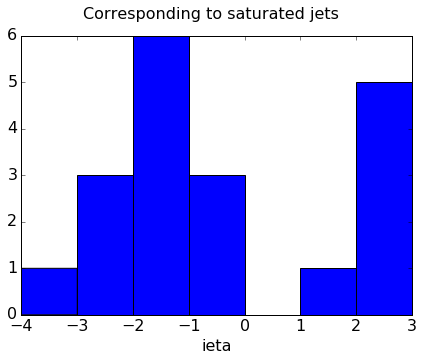

In [342]:
plt.hist(troublesome_eta, bins=np.arange(min(troublesome_eta), max(troublesome_eta)+1, 1))
plt.xlabel('ieta')
plt.suptitle('Corresponding to saturated jets')

(0, 74)

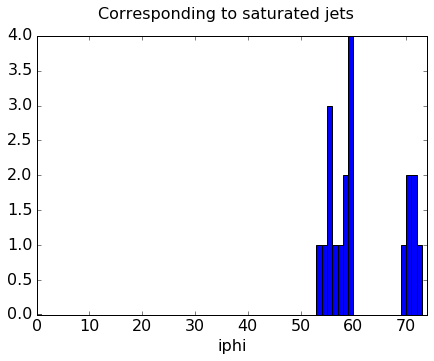

In [343]:
plt.hist(troublesome_phi, bins=range(74))
plt.xlabel('iphi')
plt.suptitle('Corresponding to saturated jets')
plt.xlim(0, 74)

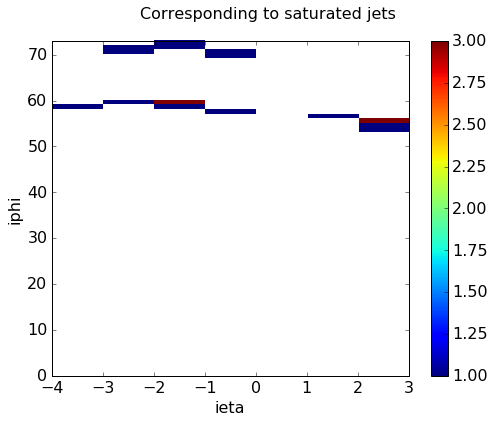

In [344]:
_ = plt.hist2d(troublesome_eta, troublesome_phi, 
               bins=[np.arange(min(troublesome_eta), max(troublesome_eta)+1, 1),
                     range(74)],
               cmin=1)
plt.ylabel('iphi')
plt.xlabel('ieta')
plt.colorbar()
plt.gcf().set_size_inches(8, 6)
plt.suptitle('Corresponding to saturated jets')

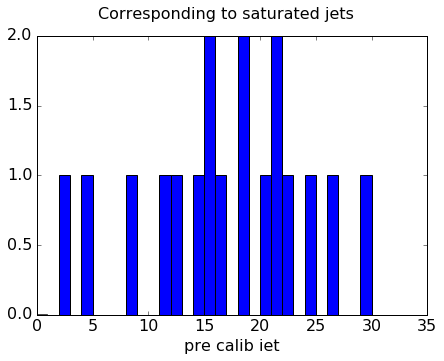

In [345]:
plt.hist(troublesome_pre_et, bins=range(max(troublesome_pre_et)))
plt.xlabel('pre calib iet')
plt.suptitle('Corresponding to saturated jets')

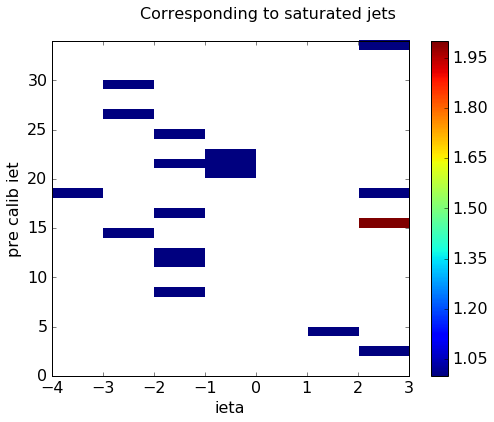

In [346]:
_ = plt.hist2d(troublesome_eta, troublesome_pre_et,
               bins=[np.arange(min(troublesome_eta), max(troublesome_eta)+1, 1),
                    range(max(troublesome_pre_et)+1)], 
               cmin=1)
plt.ylabel('pre calib iet')
plt.xlabel('ieta')
plt.colorbar()
plt.gcf().set_size_inches(8, 6)
plt.suptitle('Corresponding to saturated jets')

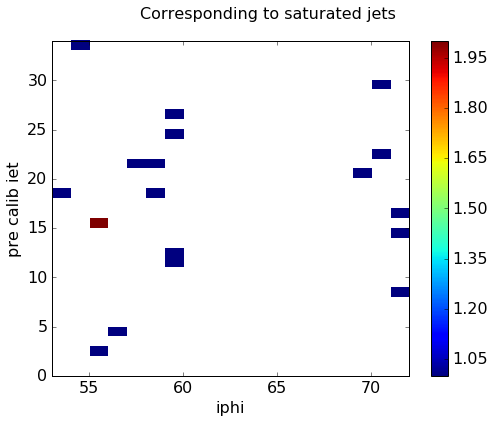

In [541]:
_ = plt.hist2d(troublesome_phi, troublesome_pre_et,
               bins=[np.arange(min(troublesome_phi), max(troublesome_phi)+1, 1),
                    range(max(troublesome_pre_et)+1)], 
               cmin=1)
plt.ylabel('pre calib iet')
plt.xlabel('iphi')
plt.colorbar()
plt.gcf().set_size_inches(8, 6)
plt.suptitle('Corresponding to saturated jets')

## Are there jets that have same et/eta/phi as saturated ones but non-saturated? 

In [347]:
# Find the "right" jet et for saturated ones using emulator jets

target_jets = []

for evt in saturated_jet_events:
    saturated_jet = [j for j in evt.data if j.et == 65535][0]
    target_jet = [j for j in evt.emu if j.match_etaphi(saturated_jet)]
    if len(target_jet) > 1:
        print target_jet
        raise RuntimeError('>1 matching jet')
    target_jets.append(target_jet[0])

In [348]:
all_data_jets = []
for e in jet_events:
    all_data_jets.extend(e.data)


In [349]:
for tj in target_jets:
    if tj in all_data_jets:
        print 'Yes, we can have', tj

Yes, we can have Jet(et=33, eta=-2, phi=72)


In [350]:
for e in jet_events:
    if Jet(et=33, eta=-2, phi=72) in e.data:
        print e.evt_num

48110844


In [351]:
for e in saturated_jet_events:
    for j in e.data:
        if j.eta == -2 and j.phi==72:
            print e.evt_num
            print j
            print e.pre_calib
            print e.post_calib
            print e.data

37212291
Jet(et=65535, eta=-2, phi=72)
[Jet(et=16, eta=1, phi=9), Jet(et=16, eta=-2, phi=72), Jet(et=18, eta=19, phi=8)]
[Jet(et=33, eta=1, phi=9), Jet(et=37, eta=19, phi=8), Jet(et=33, eta=-2, phi=72)]
[Jet(et=33, eta=1, phi=9), Jet(et=37, eta=19, phi=8), Jet(et=65535, eta=-2, phi=72)]


In [352]:
special_evt = [e for e in jet_events if e.evt_num == 48110844][0]
print special_evt.data
print special_evt.pre_calib
print special_evt.post_calib


[Jet(et=26, eta=15, phi=49), Jet(et=33, eta=-2, phi=72)]
[Jet(et=16, eta=-2, phi=72), Jet(et=13, eta=15, phi=49)]
[Jet(et=33, eta=-2, phi=72), Jet(et=26, eta=15, phi=49)]


## Data/emu discrepancies

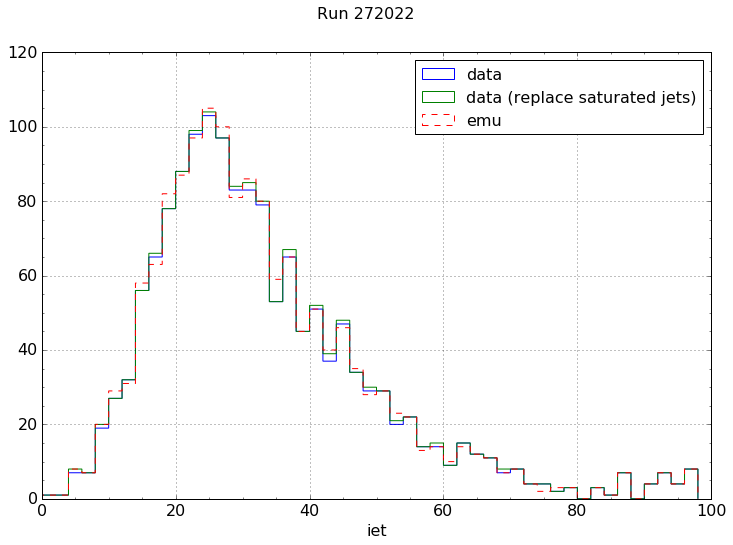

In [353]:
plt.figure(figsize=(12,8))
binning = np.arange(0, 100, 2)
data_jets_replace = []
for evt in jet_events:
    for d in evt.data:
        if d.et < 60000:
            data_jets_replace.append(d)
        else:
            nu = [j for j in evt.emu if j.match_etaphi(d)][0]
            data_jets_replace.append(nu)
        
_ = plt.hist([j.et for evt in jet_events for j in evt.data], bins=binning, histtype='step', color='blue', label='data')
_ = plt.hist([j.et for j in data_jets_replace], bins=binning, histtype='step', color='green', label='data (replace saturated jets)')
_ = plt.hist([j.et for evt in jet_events for j in evt.emu], bins=binning, histtype='step', color='red', label='emu', linestyle='dashed')
plt.legend(loc=0, fontsize=16)
plt.xlabel('iet')
plt.grid(which='major')
plt.minorticks_on()
plt.suptitle('Run 272022')

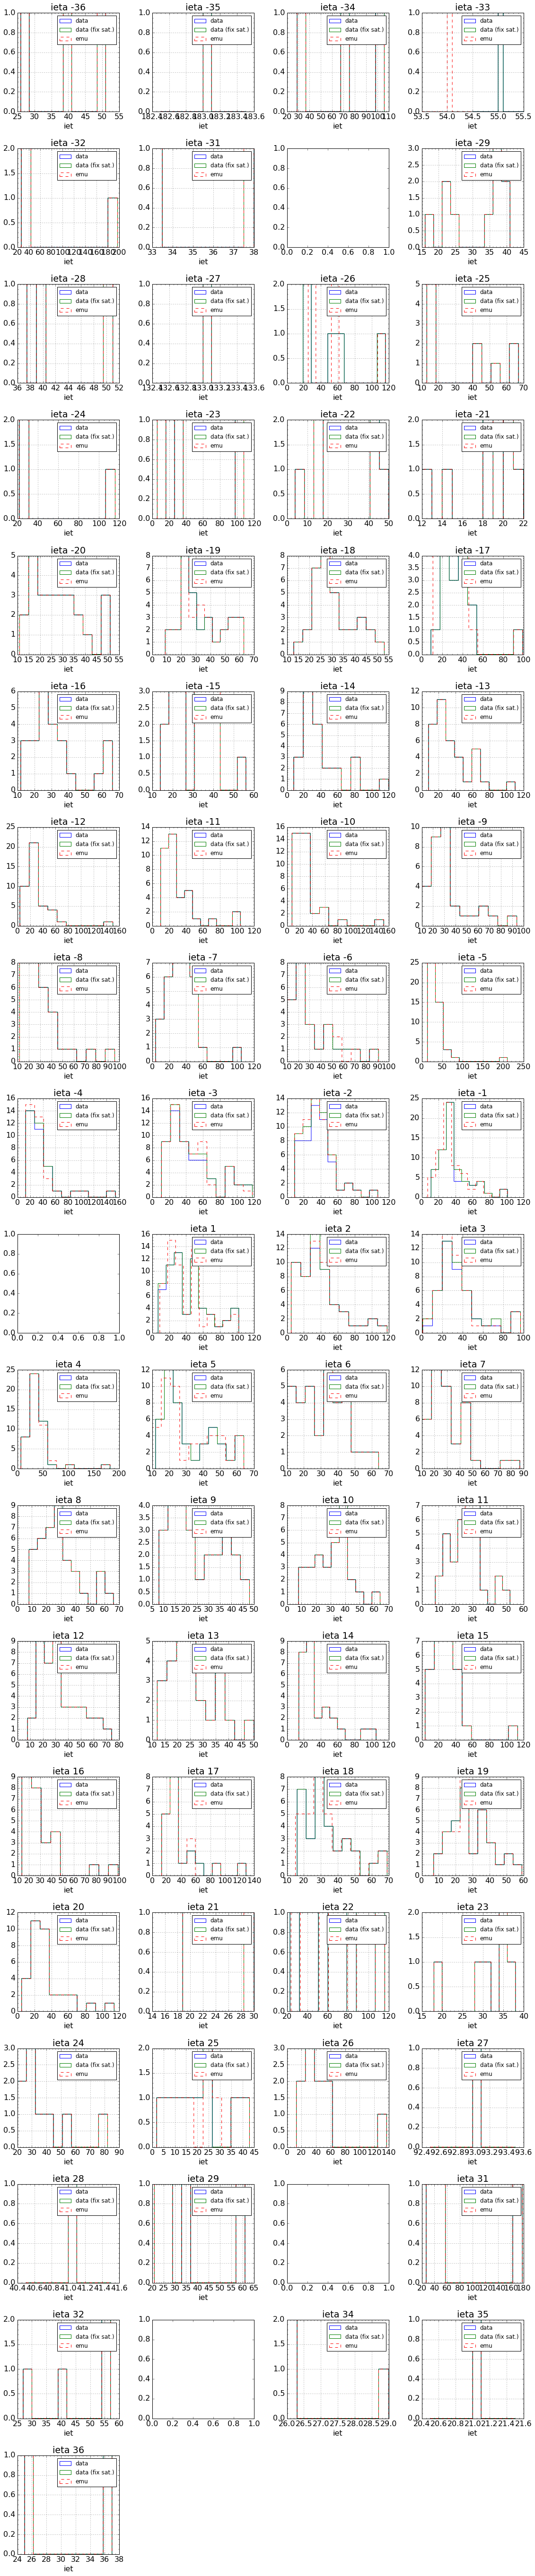

In [412]:

cols = 4
rows = 73/cols
if 73%cols != 0:
    rows += 1
plt.figure(figsize=(cols*4, rows*4))
binning = np.arange(0, 100, 2)

for ind, ieta in enumerate(np.arange(-36, 37)):
    plt.subplot(rows, cols, ind+1)
    ieta = int(ieta)        
    if len([j.et for evt in jet_events for j in evt.data if j.eta == ieta]) > 0:
        _ = plt.hist([j.et for evt in jet_events for j in evt.data if j.eta == ieta if j.et != 65535], histtype='step', color='blue', label='data')
        _ = plt.gca().hist([j.et for j in data_jets_replace if j.eta == ieta], histtype='step', color='green', label='data (fix sat.)')
        _ = plt.gca().hist([j.et for evt in jet_events for j in evt.emu if j.eta == ieta], histtype='step', color='red', label='emu', linestyle='dashed')
        plt.legend(loc=0, fontsize=12)
        plt.xlabel('iet')
        plt.grid(which='major')
        plt.minorticks_on()
        plt.gca().set_title('ieta %d' % ieta)
plt.tight_layout()
#     plt.suptitle('Run 272022, ieta=%d' % ieta)

In [453]:
def print_jets(ieta):
    for evt in jet_events:
        for j in evt.data:
            if j.eta == ieta:
                print 'Data:', j
        for j in evt.emu:
            if j.eta == ieta:
                print 'Emu:', j
        

In [454]:
print_jets(25)

Data: Jet(et=18, eta=25, phi=33)
Emu: Jet(et=18, eta=25, phi=33)
Data: Jet(et=22, eta=25, phi=64)
Emu: Jet(et=28, eta=25, phi=64)
Data: Jet(et=11, eta=25, phi=32)
Emu: Jet(et=11, eta=25, phi=32)
Data: Jet(et=43, eta=25, phi=43)
Emu: Jet(et=43, eta=25, phi=43)
Data: Jet(et=36, eta=25, phi=29)
Emu: Jet(et=36, eta=25, phi=29)
Data: Jet(et=25, eta=25, phi=22)
Emu: Jet(et=25, eta=25, phi=22)
Data: Jet(et=9, eta=25, phi=1)
Emu: Jet(et=9, eta=25, phi=1)
Data: Jet(et=25, eta=25, phi=62)
Emu: Jet(et=25, eta=25, phi=62)
Data: Jet(et=2, eta=25, phi=46)
Emu: Jet(et=2, eta=25, phi=46)


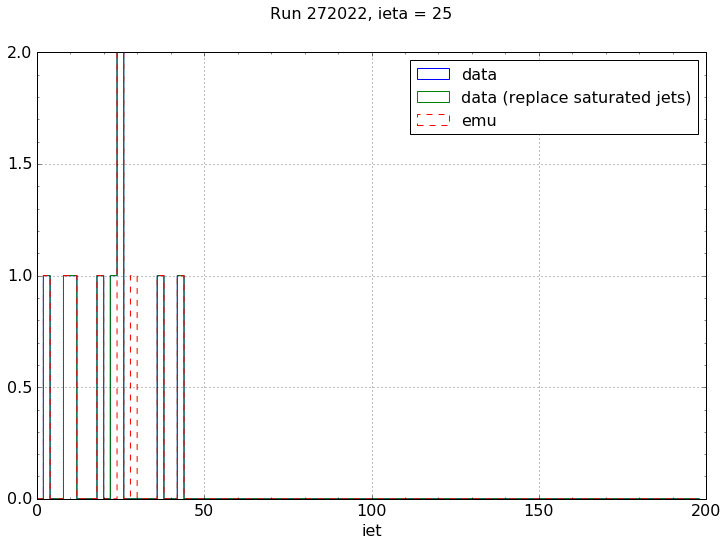

In [452]:
plt.figure(figsize=(12,8))
binning = np.arange(0, 200, 2)

ieta = 25
_ = plt.hist([j.et for evt in jet_events for j in evt.data if j.eta == ieta], bins=binning, histtype='step', color='blue', label='data')
_ = plt.hist([j.et for j in data_jets_replace if j.eta == ieta], bins=binning, histtype='step', color='green', label='data (replace saturated jets)')
_ = plt.hist([j.et for evt in jet_events for j in evt.emu if j.eta == ieta], bins=binning, histtype='step', color='red', label='emu', linestyle='dashed')
plt.legend(loc=0, fontsize=16)
plt.xlabel('iet')
plt.grid(which='major')
plt.minorticks_on()
plt.suptitle('Run 272022, ieta = %d' % ieta)

In [354]:
MatchedJets = namedtuple('MatchedJets', 'data emu pre')

In [355]:
# do matching for each event
matched_pairs_events = []
for evt in jet_events:
    matched_pairs = []
    for d, j, p in product(evt.data, evt.emu, evt.pre_calib):
        if d.match_etaphi(j) and d.match_etaphi(p):
            matched_pairs.append(MatchedJets(d, j, p))
#     print matched_pairs
    if len(matched_pairs) != len(evt.data):
        raise RuntimeError('Missing matches')

    matched_pairs_events.append(matched_pairs)

print matched_pairs_events[:3]

[[MatchedJets(data=Jet(et=27, eta=1, phi=32), emu=Jet(et=27, eta=1, phi=32), pre=Jet(et=13, eta=1, phi=32)), MatchedJets(data=Jet(et=46, eta=6, phi=24), emu=Jet(et=46, eta=6, phi=24), pre=Jet(et=23, eta=6, phi=24)), MatchedJets(data=Jet(et=16, eta=21, phi=32), emu=Jet(et=16, eta=21, phi=32), pre=Jet(et=8, eta=21, phi=32))], [MatchedJets(data=Jet(et=7, eta=2, phi=5), emu=Jet(et=7, eta=2, phi=5), pre=Jet(et=3, eta=2, phi=5)), MatchedJets(data=Jet(et=22, eta=15, phi=61), emu=Jet(et=22, eta=15, phi=61), pre=Jet(et=11, eta=15, phi=61))], [MatchedJets(data=Jet(et=19, eta=2, phi=51), emu=Jet(et=19, eta=2, phi=51), pre=Jet(et=9, eta=2, phi=51)), MatchedJets(data=Jet(et=36, eta=13, phi=44), emu=Jet(et=36, eta=13, phi=44), pre=Jet(et=18, eta=13, phi=44))]]


In [459]:
et_ratio = []
et_diff = []
for mp_evt in matched_pairs_events:
    for pair in mp_evt:
        if pair.data.et == 65535:
            continue
        if pair.data != pair.emu:
#             print pair
            et_ratio.append(pair.data.et / float(pair.emu.et))
            if et_ratio[-1] > 10:
                print pair.data, pair.emu
            et_diff.append(pair.data.et - pair.emu.et)
#             print pair.data.et - pair.emu.et

In [478]:
right_calib_jets = [mp for mpe in matched_pairs_events for mp in mpe if mp.data.et == mp.emu.et and mp.data.et != 65535]

In [473]:
wrong_calib_jets = [mp for mpe in matched_pairs_events for mp in mpe if mp.data.et != mp.emu.et and mp.data.et != 65535]

In [539]:
saturated_jets = [mp for mpe in matched_pairs_events for mp in mpe if mp.data.et == 65535]

In [476]:
print Counter([x.data.eta for x in wrong_calib_jets]).most_common()

[(18, 7), (-3, 7), (1, 6), (20, 6), (2, 5), (-19, 5), (-1, 5), (3, 3), (17, 3), (-5, 3), (-4, 3), (4, 2), (-20, 2), (-7, 2), (-6, 2), (-2, 2), (5, 1), (19, 1), (22, 1), (25, 1), (-33, 1), (-26, 1), (-22, 1), (-18, 1), (-17, 1)]


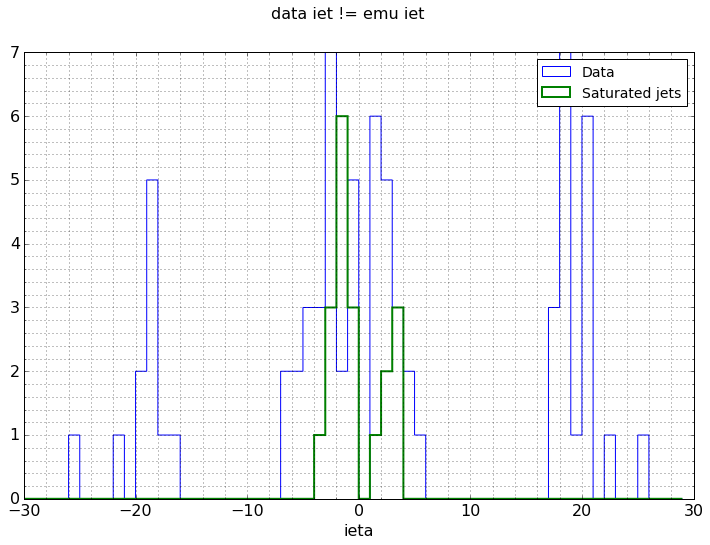

In [525]:
plt.figure(figsize=(12, 8))
binning = np.arange(-30, 30, 1)
_ = plt.hist([x.data.eta for x in wrong_calib_jets], 
             bins=binning, color='blue', histtype='step', label='Data')
_ = plt.hist([mp.data.eta for mpe in matched_pairs_events for mp in mpe if mp.data.et != mp.emu.et and mp.data.et == 65535], 
             bins=binning, color='green', histtype='step', label='Saturated jets', linewidth=2)
plt.xlabel('ieta')
plt.suptitle('data iet != emu iet')
plt.minorticks_on()
plt.legend(loc=0, fontsize=14)
plt.grid(which='both')

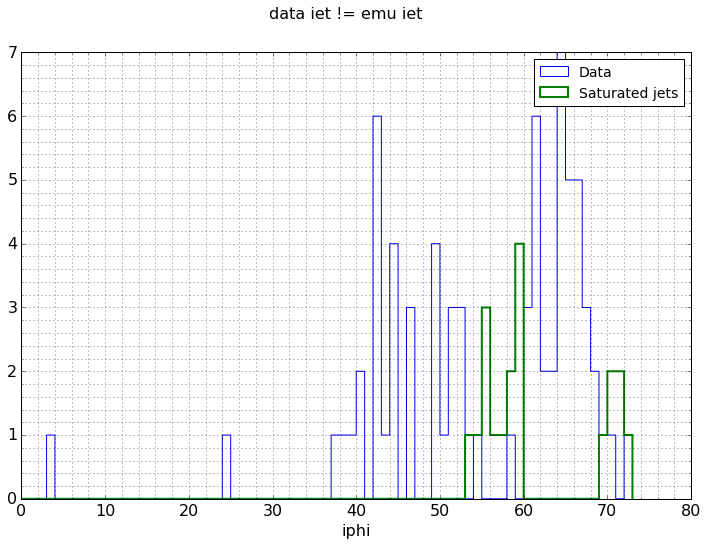

In [524]:
plt.figure(figsize=(12, 8))
binning = np.arange(0, 74, 1)
_ = plt.hist([x.data.phi for x in wrong_calib_jets], 
             bins=binning, color='blue', histtype='step', label='Data')
_ = plt.hist([mp.data.phi for mpe in matched_pairs_events for mp in mpe if mp.data.et != mp.emu.et and mp.data.et == 65535], 
             bins=binning, color='green', histtype='step', label='Saturated jets', linewidth=2)
plt.xlabel('iphi')
plt.suptitle('data iet != emu iet')
plt.minorticks_on()
plt.legend(loc='best', fontsize=14)
plt.grid(which='both')

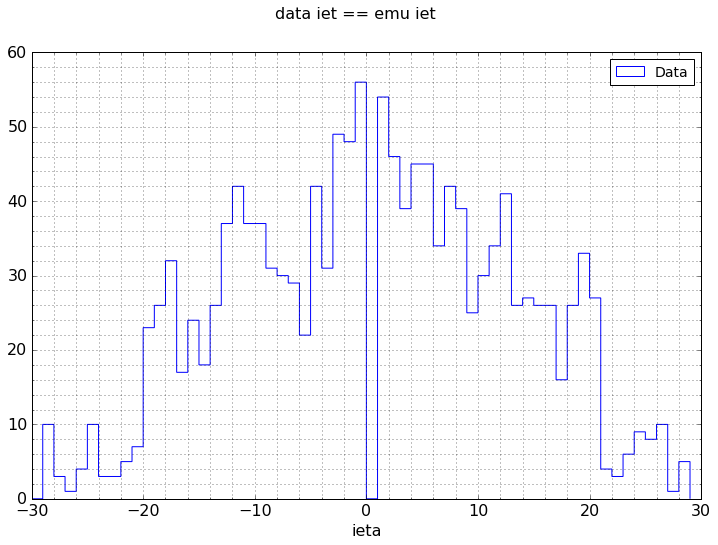

In [479]:
plt.figure(figsize=(12, 8))
binning = np.arange(-30, 30, 1)
_ = plt.hist([x.data.eta for x in right_calib_jets], 
             bins=binning, color='blue', histtype='step', label='Data')
plt.xlabel('ieta')
plt.suptitle('data iet == emu iet')
plt.minorticks_on()
plt.legend(loc=0, fontsize=14)
plt.grid(which='both')

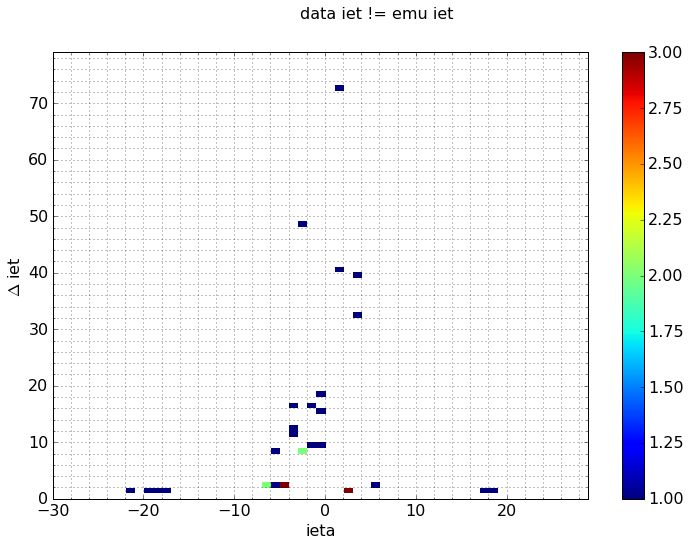

In [480]:
plt.figure(figsize=(12, 8))
binning = [np.arange(-30, 30, 1), range(80)]
_ = plt.hist2d([x.data.eta for x in wrong_calib_jets],
               [x.data.et - x.emu.et for x in wrong_calib_jets],
               bins=binning, cmin=1)
# _ = plt.hist([mp.data.eta for mpe in matched_pairs_events for mp in mpe if mp.data.et != mp.emu.et and mp.data.et == 65535], 
#              bins=binning, color='green', histtype='step', label='Saturated jets', linestyle='dashed')
plt.xlabel('ieta')
plt.ylabel(r'$\Delta$' + ' iet')
plt.suptitle('data iet != emu iet')
plt.minorticks_on()
plt.legend(loc=0, fontsize=14)
plt.grid(which='both')
plt.colorbar()

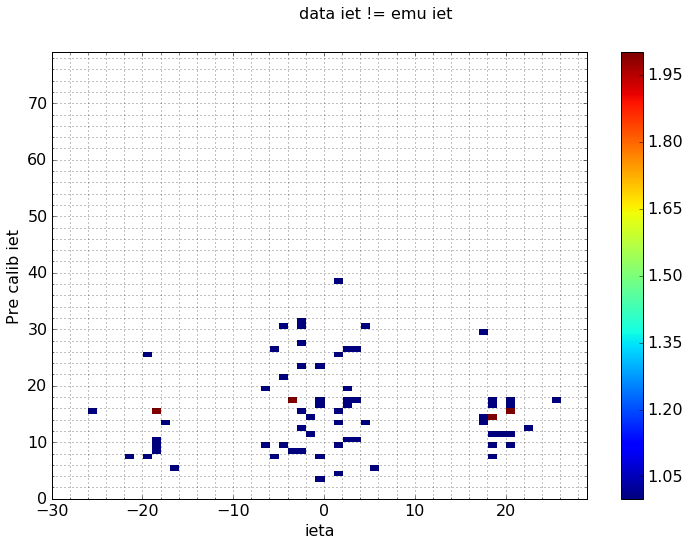

In [491]:
plt.figure(figsize=(12, 8))
binning = [np.arange(-30, 30, 1), range(80)]
_ = plt.hist2d([x.data.eta for x in wrong_calib_jets],
               [x.pre.et for x in wrong_calib_jets],
               bins=binning, cmin=1)
plt.xlabel('ieta')
plt.ylabel('Pre calib iet')
plt.suptitle('data iet != emu iet')
plt.minorticks_on()
plt.legend(loc=0, fontsize=14)
plt.grid(which='both')
plt.colorbar()

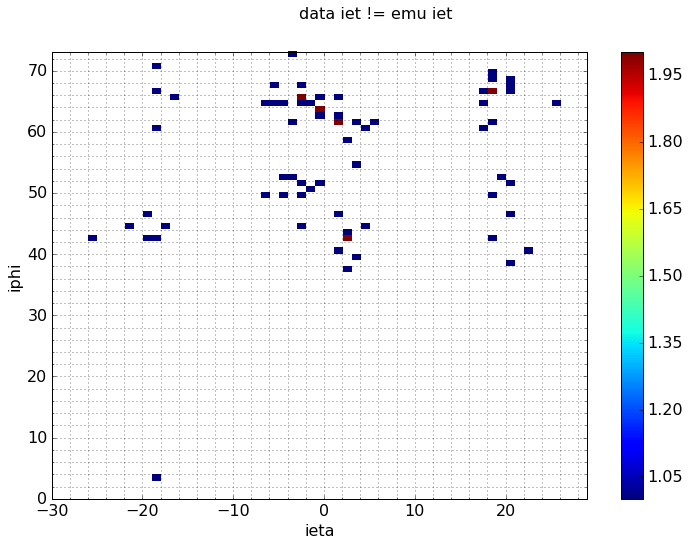

In [526]:
plt.figure(figsize=(12, 8))
binning = [np.arange(-30, 30, 1), range(74)]
_ = plt.hist2d([x.data.eta for x in wrong_calib_jets],
               [x.pre.phi for x in wrong_calib_jets],
               bins=binning, cmin=1)
plt.xlabel('ieta')
plt.ylabel('iphi')
plt.suptitle('data iet != emu iet')
plt.minorticks_on()
plt.legend(loc=0, fontsize=14)
plt.grid(which='both')
plt.colorbar()

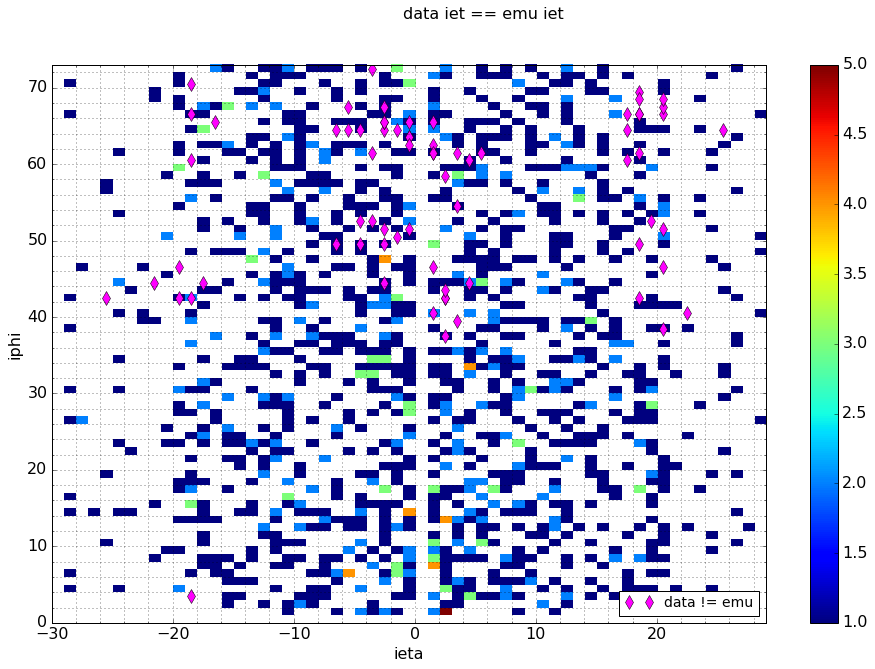

In [531]:
plt.figure(figsize=(16, 10))
binning = [np.arange(-30, 30, 1), range(74)]
_ = plt.hist2d([x.data.eta for x in right_calib_jets],
               [x.pre.phi for x in right_calib_jets],
               bins=binning, cmin=1)
plt.plot([x.data.eta + 0.5 for x in wrong_calib_jets], [x.pre.phi+0.5 for x in wrong_calib_jets], 'd', 
         label='data != emu', color='magenta', markersize=10)

plt.xlabel('ieta')
plt.ylabel('iphi')
plt.suptitle('data iet == emu iet')
plt.minorticks_on()
plt.legend(loc=0, fontsize=14)
plt.grid(which='both')
plt.colorbar()

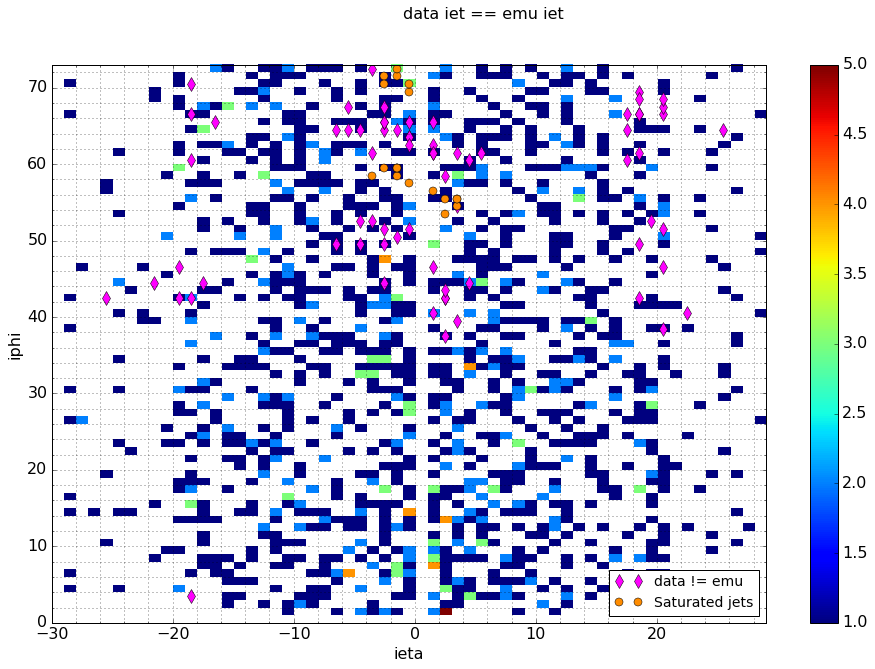

In [536]:
plt.figure(figsize=(16, 10))
binning = [np.arange(-30, 30, 1), range(74)]
_ = plt.hist2d([x.data.eta for x in right_calib_jets],
               [x.pre.phi for x in right_calib_jets],
               bins=binning, cmin=1)
plt.plot([x.data.eta + 0.5 for x in wrong_calib_jets], [x.pre.phi+0.5 for x in wrong_calib_jets], 'd', 
         label='data != emu', color='magenta', markersize=10)
plt.plot([e+0.5 for e in troublesome_eta], [e+0.5 for e in troublesome_phi], 
         'o', label='Saturated jets', color='darkorange', markersize=8)

plt.xlabel('ieta')
plt.ylabel('iphi')
plt.suptitle('data iet == emu iet')
plt.minorticks_on()
plt.legend(loc=0, fontsize=14)
plt.grid(which='both')
plt.colorbar()

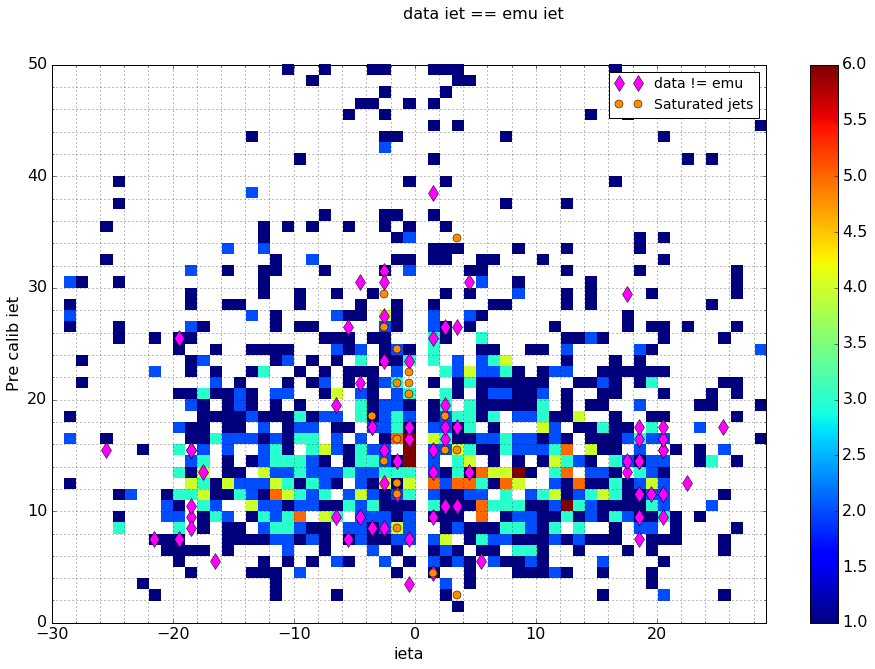

In [538]:
plt.figure(figsize=(16, 10))
binning = [np.arange(-30, 30, 1), range(51)]
_ = plt.hist2d([x.data.eta for x in right_calib_jets],
               [x.pre.et for x in right_calib_jets],
               bins=binning, cmin=1)
plt.plot([x.data.eta + 0.5 for x in wrong_calib_jets], [x.pre.et+0.5 for x in wrong_calib_jets], 'd', 
         label='data != emu', color='magenta', markersize=12)
plt.plot([e+0.5 for e in troublesome_eta], [e+0.5 for e in troublesome_pre_et], 
         'o', label='Saturated jets', color='darkorange', markersize=8)
plt.xlabel('ieta')
plt.ylabel('Pre calib iet')
plt.suptitle('data iet == emu iet')
plt.minorticks_on()
plt.legend(loc=0, fontsize=14)
plt.grid(which='both')
plt.colorbar()


In [482]:
print len(right_calib_jets), len(wrong_calib_jets)

1455 72


In [481]:
for mis_mp in wrong_calib_jets:
    target = mis_mp.emu
    for right_mp in right_calib_jets:
        if right_mp.data == target:
            print target

Jet(et=17, eta=-3, phi=49)


In [486]:

for mis_mp in wrong_calib_jets:
    possibles = []
    target = mis_mp.emu
    print 'Target:', target
    for right_mp in right_calib_jets:
        if right_mp.data.eta == target.eta and right_mp.data.et == target.et:
            print 'Match:', target


Target: Jet(et=19, eta=1, phi=61)
Match: Jet(et=19, eta=1, phi=61)
Target: Jet(et=52, eta=-6, phi=67)
Target: Jet(et=31, eta=1, phi=62)
Match: Jet(et=31, eta=1, phi=62)
Match: Jet(et=31, eta=1, phi=62)
Target: Jet(et=60, eta=-5, phi=49)
Target: Jet(et=33, eta=-1, phi=51)
Match: Jet(et=33, eta=-1, phi=51)
Match: Jet(et=33, eta=-1, phi=51)
Match: Jet(et=33, eta=-1, phi=51)
Match: Jet(et=33, eta=-1, phi=51)
Match: Jet(et=33, eta=-1, phi=51)
Match: Jet(et=33, eta=-1, phi=51)
Target: Jet(et=27, eta=4, phi=60)
Match: Jet(et=27, eta=4, phi=60)
Target: Jet(et=55, eta=-3, phi=67)
Match: Jet(et=55, eta=-3, phi=67)
Match: Jet(et=55, eta=-3, phi=67)
Match: Jet(et=55, eta=-3, phi=67)
Match: Jet(et=55, eta=-3, phi=67)
Target: Jet(et=28, eta=25, phi=64)
Target: Jet(et=35, eta=3, phi=61)
Match: Jet(et=35, eta=3, phi=61)
Target: Jet(et=21, eta=3, phi=54)
Match: Jet(et=21, eta=3, phi=54)
Target: Jet(et=23, eta=18, phi=66)
Match: Jet(et=23, eta=18, phi=66)
Target: Jet(et=14, eta=-22, phi=44)
Match: Jet(e

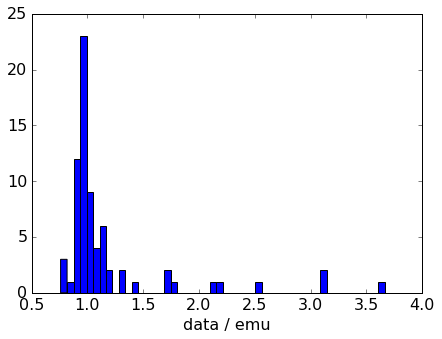

In [467]:
_ = plt.hist(et_ratio, bins=50)
plt.xlabel('data / emu')
# plt.xscale('log')

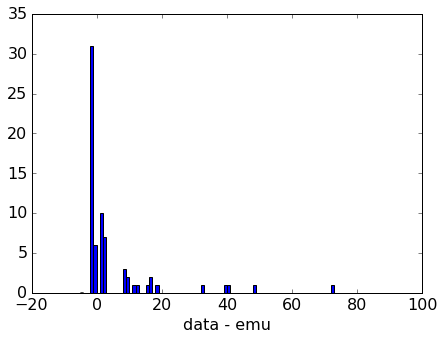

In [466]:
_ = plt.hist(et_diff, range=[-5, 100], bins=105)
plt.xlabel('data - emu')